# Urban Heat Island Effect Mitigation for Chandigarh City

This notebook provides a detailed analysis and solution for mitigating the Urban Heat Island (UHI) effect in Chandigarh city. The solution includes data preprocessing, exploratory data analysis, hot spot identification, predictive modeling, cooling action suggestions, and effectiveness monitoring.

## Steps:
1. Data Cleaning and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Hot Spot Identification
4. Predictive Modeling
5. Cooling Action Suggestions
6. Effectiveness Monitoring


# Linking Google Drive

In [11]:
from google.colab import drive

drive.mount('/content/drive')  # Mount to /content/drive

# Access your folder using the escaped space:
import os
os.chdir('/content/drive/My Drive/UHI-Mitigation/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Necessary Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.impute import KNNImputer
import folium
from folium.plugins import HeatMap
import ee
import geemap
from datetime import timedelta
import ast
from prophet import Prophet

## Initializing Google Earth Engine

In [13]:
ee.Authenticate()
ee.Initialize(project='ee-donotmess990')
os.chdir('/content/drive/My Drive/UHI-Mitigation/')

## Dataset Generation

**A. CHANDIGARH REGION**

1. Dynamically retrieves Chandigarh's regional boundaries using the FAO GAUL dataset.

2. Extracts the geometry of these regions for environmental analysis.

3. Converts MODIS LST (Land Surface Temperature) from Kelvin to Celsius and
processes NDVI, EVI, albedo, population density, and NO2 datasets for these regions.

4. Aggregates data over monthly intervals for UHI (Urban Heat Island) effect analysis.

5. Saving them in a structured format (chandigarh_regions_data.csv).


In [16]:
import ee
import pandas as pd
from datetime import datetime, timedelta

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize()

# Define Chandigarh regions dynamically from FAO GAUL dataset
chandigarh = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Chandigarh'))
regions = {}
features = chandigarh.getInfo()['features']
for feature in features:
    region_name = feature['properties']['ADM2_NAME']
    regions[region_name] = ee.Feature(feature['geometry']).geometry()

# Helper function for Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15)

# Function to calculate stats
def get_stats(image, region, name):
    if image:
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
            geometry=region, scale=500, maxPixels=1e9
        ).getInfo()
        return stats.get(f'{name}_mean'), stats.get(f'{name}_stdDev')
    return None, None

# Function to process data for a given period
def process_region_data(start_date, end_date, region_name, region_geometry):
    try:
        # LST for UHI
        modis_lst = ee.ImageCollection('MODIS/061/MOD11A1')
        lst_day = kelvin_to_celsius(
            modis_lst.filterDate(start_date, end_date).select('LST_Day_1km').mean()
        ).clip(region_geometry)

        # NDVI, EVI, EVI2
        viirs_collection = ee.ImageCollection("NASA/VIIRS/002/VNP13A1").filterDate(start_date, end_date)
        viirs_ndvi = viirs_collection.select('NDVI').mean().clip(region_geometry)
        viirs_evi = viirs_collection.select('EVI').mean().clip(region_geometry)
        viirs_evi2 = viirs_collection.select('EVI2').mean().clip(region_geometry)

        # Population Density
        population = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2020-01-01', '2021-01-01').mean().clip(region_geometry)

        # Albedo
        albedo = ee.ImageCollection('MODIS/061/MCD43A3').filterDate(start_date, end_date).select('Albedo_BSA_shortwave').mean().clip(region_geometry)

        # NO2
        no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(start_date, end_date).select('NO2_column_number_density').mean().clip(region_geometry)

        # Extract stats
        ndvi_mean, ndvi_std = get_stats(viirs_ndvi, region_geometry, 'NDVI')
        evi_mean, evi_std = get_stats(viirs_evi, region_geometry, 'EVI')
        evi2_mean, evi2_std = get_stats(viirs_evi2, region_geometry, 'EVI2')
        pop_mean, pop_std = get_stats(population, region_geometry, 'population_density')
        albedo_mean, albedo_std = get_stats(albedo, region_geometry, 'Albedo_BSA_shortwave')
        no2_mean, no2_std = get_stats(no2, region_geometry, 'NO2_column_number_density')

        # Urban and non-urban temps
        landcover = ee.Image('MODIS/061/MCD12Q1/2019_01_01').select('LC_Type1')
        urban_areas = landcover.eq(13)
        urban_temp = lst_day.updateMask(urban_areas).reduceRegion(
            reducer=ee.Reducer.mean(), geometry=region_geometry, scale=500, maxPixels=1e9
        ).get('LST_Day_1km')
        non_urban_temp = lst_day.updateMask(urban_areas.eq(0)).reduceRegion(
            reducer=ee.Reducer.mean(), geometry=region_geometry, scale=500, maxPixels=1e9
        ).get('LST_Day_1km')
        uhi = ee.Number(urban_temp).subtract(ee.Number(non_urban_temp)).getInfo() if urban_temp and non_urban_temp else None

        return {
            'region': region_name,
            'start_date': start_date,
            'end_date': end_date,
            'uhi': uhi,
            'ndvi_mean': ndvi_mean,
            'ndvi_std': ndvi_std,
            'evi_mean': evi_mean,
            'evi_std': evi_std,
            'evi2_mean': evi2_mean,
            'evi2_std': evi2_std,
            'population_mean': pop_mean,
            'population_std': pop_std,
            'albedo_mean': albedo_mean,
            'albedo_std': albedo_std,
            'no2_mean': no2_mean,
            'no2_std': no2_std
        }
    except Exception as e:
        print(f"Error processing data for {region_name} from {start_date} to {end_date}: {e}")
        return None

# Time intervals
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 1, 1)
interval = timedelta(days=30)

# Loop through time intervals and regions
data_list = []
current_date = start_date
while current_date < end_date:
    next_date = current_date + interval
    for region_name, region_geometry in regions.items():
        data = process_region_data(
            current_date.strftime('%Y-%m-%d'),
            next_date.strftime('%Y-%m-%d'),
            region_name,
            region_geometry
        )
        if data:
            data_list.append(data)
    current_date = next_date

# Save to CSV
df = pd.DataFrame(data_list)
df.to_csv('chandigarh_regions_data.csv', index=False)
print("Data saved to chandigarh_regions_data.csv")


Data saved to chandigarh_regions_data.csv


**B. UHI DATA**

1. Iterates through 16-day time intervals from 2018 to 2024.
2. Collects environmental and climatic data for Chandigarh (e.g., LST, NDVI, NO2) and computes UHI by comparing urban vs. non-urban temperatures.
3. Extracts data for additional features like albedo and population density, saving them in a structured format (uhi_vs_features_16_day_intervals.csv).


In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.impute import KNNImputer
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define cities and region of interest
cities = {
    'Chandigarh': (30.7333, 76.7794)
}

region_interest = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(
    ee.Filter.eq('ADM2_NAME', 'Chandigarh')
)

start_date = datetime.strptime('2018-07-12', '%Y-%m-%d')
end_date = datetime.strptime('2024-01-01', '%Y-%m-%d')

# Helper function to convert Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15)

# Function to load and process a collection
def load_and_process_collection(collection, date_range, band, operation='mean'):
    try:
        data = collection.filterDate(*date_range)
        if data.size().getInfo() == 0:
            print(f"No {band} data available for the specified date range.")
            return None
        return getattr(data.select(band), operation)().clip(region_interest)
    except Exception as e:
        print(f"Error loading {band}: {str(e)}")
        return None

# Function to get city values from an image
def get_city_values(image, cities):
    if image is None:
        return {city: None for city in cities}
    values = {}
    for city, coords in cities.items():
        try:
            point = ee.Geometry.Point(coords[::-1])
            value = image.sample(point, 1000).first().get(image.bandNames().get(0)).getInfo()
            values[city] = value
        except Exception as e:
            print(f"Error getting value for {city}: {str(e)}")
            values[city] = None
    return values

data_list = []

current_date = start_date
while current_date < end_date:
    next_date = current_date + timedelta(days=16)
    date_range = (current_date.strftime('%Y-%m-%d'), next_date.strftime('%Y-%m-%d'))

    print(f"Processing date range: {date_range}")
    modis_lst = load_and_process_collection(
        ee.ImageCollection('MODIS/061/MOD11A2'), date_range, 'LST_Day_1km'
    )
    if modis_lst is not None:
        wb_lst = kelvin_to_celsius(modis_lst)

        landcover = ee.Image('MODIS/061/MCD12Q1/2019_01_01').select('LC_Type1')
        urban_areas = landcover.eq(13)

        try:
            urban_temp = wb_lst.updateMask(urban_areas).reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_interest.geometry(),
                scale=1000,
                maxPixels=1e9
            ).get('LST_Day_1km')
            non_urban_temp = wb_lst.updateMask(urban_areas.eq(0)).reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_interest.geometry(),
                scale=1000,
                maxPixels=1e9
            ).get('LST_Day_1km')
            uhi_map = wb_lst.subtract(ee.Image.constant(non_urban_temp))
        except Exception as e:
            print(f"Error calculating UHI map: {str(e)}")
            uhi_map = None

        # Load additional datasets
        ndvi = load_and_process_collection(
            ee.ImageCollection('MODIS/061/MOD13Q1'), date_range, 'NDVI'
        )
        population = load_and_process_collection(
            ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density"),
            ('2020-01-01', '2021-01-01'),
            'population_density'
        )
        albedo = load_and_process_collection(
            ee.ImageCollection('MODIS/061/MCD43A3'), date_range, 'Albedo_BSA_shortwave'
        )
        no2_total = load_and_process_collection(
            ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2'), date_range, 'NO2_column_number_density'
        )
        no2_tropospheric = load_and_process_collection(
            ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2'), date_range, 'tropospheric_NO2_column_number_density'
        )
        no2_stratospheric = load_and_process_collection(
            ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2'), date_range, 'stratospheric_NO2_column_number_density'
        )
        aerosol_index = load_and_process_collection(
            ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2'), date_range, 'absorbing_aerosol_index'
        )
        cloud_fraction = load_and_process_collection(
            ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2'), date_range, 'cloud_fraction'
        )
        ghsl_built = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_C").filterDate(
            '2018-01-01', '2018-12-31').first().clip(region_interest)

        if albedo is not None:
            albedo = albedo.multiply(0.001)

        datasets = {
            'UHI': uhi_map,
            'NDVI': ndvi,
            'Population': population,
            'Albedo': albedo,
            'NO2_Total': no2_total,
            'NO2_Tropospheric': no2_tropospheric,
            'NO2_Stratospheric': no2_stratospheric,
            'Aerosol_Index': aerosol_index,
            'Cloud_Fraction': cloud_fraction,
            'GHSL_Built': ghsl_built,
        }

        city_data = {param: get_city_values(image, cities) for param, image in datasets.items()}
        city_data['Date'] = current_date.strftime('%Y-%m-%d')

        # Validate data before appending
        if all(value is not None for value in city_data.values()):
            data_list.append(city_data)

    current_date = next_date

df = pd.DataFrame(data_list)

# Parse JSON-like columns
def parse_json_like_column(column):
    return column.apply(lambda x: x['Chandigarh'] if isinstance(x, dict) else None)

columns_to_parse = ['UHI', 'NDVI', 'Population', 'Albedo', 'NO2_Total', 'NO2_Tropospheric',
                    'NO2_Stratospheric', 'Aerosol_Index', 'Cloud_Fraction', 'GHSL_Built']

for col in columns_to_parse:
    df[col] = parse_json_like_column(df[col])

df['Date'] = pd.to_datetime(df['Date'])

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=['Date'])), columns=df.columns[:-1])
df_imputed['Date'] = df['Date']
df = df_imputed[['Date'] + [col for col in df_imputed.columns if col != 'Date']]

# Save the processed data to a CSV file
df.to_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv', index=False)
print("Data saved to uhi_vs_features_16_day_intervals.csv")
print(df.head())


Processing date range: ('2018-07-12', '2018-07-28')
Processing date range: ('2018-07-28', '2018-08-13')
Processing date range: ('2018-08-13', '2018-08-29')
Processing date range: ('2018-08-29', '2018-09-14')
Processing date range: ('2018-09-14', '2018-09-30')
Processing date range: ('2018-09-30', '2018-10-16')
Processing date range: ('2018-10-16', '2018-11-01')
Processing date range: ('2018-11-01', '2018-11-17')
Processing date range: ('2018-11-17', '2018-12-03')
Processing date range: ('2018-12-03', '2018-12-19')
Processing date range: ('2018-12-19', '2019-01-04')
Processing date range: ('2019-01-04', '2019-01-20')
Processing date range: ('2019-01-20', '2019-02-05')
Processing date range: ('2019-02-05', '2019-02-21')
Processing date range: ('2019-02-21', '2019-03-09')
Processing date range: ('2019-03-09', '2019-03-25')
Processing date range: ('2019-03-25', '2019-04-10')
Processing date range: ('2019-04-10', '2019-04-26')
Processing date range: ('2019-04-26', '2019-05-12')
Processing d

Processing date range: ('2022-11-12', '2022-11-28')
Processing date range: ('2022-11-28', '2022-12-14')
Processing date range: ('2022-12-14', '2022-12-30')
Processing date range: ('2022-12-30', '2023-01-15')
Processing date range: ('2023-01-15', '2023-01-31')
Processing date range: ('2023-01-31', '2023-02-16')
Processing date range: ('2023-02-16', '2023-03-04')
Processing date range: ('2023-03-04', '2023-03-20')
Processing date range: ('2023-03-20', '2023-04-05')
Processing date range: ('2023-04-05', '2023-04-21')
Processing date range: ('2023-04-21', '2023-05-07')
Processing date range: ('2023-05-07', '2023-05-23')
Processing date range: ('2023-05-23', '2023-06-08')
Processing date range: ('2023-06-08', '2023-06-24')
Processing date range: ('2023-06-24', '2023-07-10')
Processing date range: ('2023-07-10', '2023-07-26')
Error getting value for Chandigarh: Element.get: Parameter 'object' is required and may not be null.
Processing date range: ('2023-07-26', '2023-08-11')
Error getting v

## Area wise Data Extraction

In [38]:
import ee
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define multiple regions dynamically for Chandigarh using FAO GAUL dataset
chandigarh = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Chandigarh'))
regions = {}
features = chandigarh.getInfo()['features']
for i, feature in enumerate(features):
    region_name = f"Region_{i+1}"  # Assign unique names to each region
    regions[region_name] = ee.Feature(feature['geometry']).geometry()

# Helper function to convert Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15)

# Helper function to calculate stats
def get_stats(image, region, name):
    if image is not None:
        try:
            stats = image.reduceRegion(
                reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
                geometry=region, scale=1000, maxPixels=1e9
            ).getInfo()
            return stats.get(f'{name}_mean'), stats.get(f'{name}_stdDev')
        except Exception as e:
            print(f"Error calculating stats for {name}: {e}")
    return None, None

# Function to process data for a given period
def get_data_for_period(start_date, end_date, region_name, region_geometry):
    try:
        # MODIS LST for UHI calculation
        modis_lst = ee.ImageCollection('MODIS/061/MOD11A1')
        region_lst = kelvin_to_celsius(
            modis_lst.filterDate(start_date, end_date).mean().select('LST_Day_1km')
        ).clip(region_geometry)

        landcover = ee.Image('MODIS/006/MCD12Q1/2019_01_01').select('LC_Type1')
        urban_areas = landcover.eq(13)

        urban_temp = region_lst.updateMask(urban_areas).reduceRegion(
            reducer=ee.Reducer.mean(), geometry=region_geometry, scale=1000, maxPixels=1e9
        ).get('LST_Day_1km')
        non_urban_temp = region_lst.updateMask(urban_areas.eq(0)).reduceRegion(
            reducer=ee.Reducer.mean(), geometry=region_geometry, scale=1000, maxPixels=1e9
        ).get('LST_Day_1km')

        uhi_value = None
        if urban_temp is not None and non_urban_temp is not None:
            uhi_value = ee.Number(urban_temp).subtract(ee.Number(non_urban_temp)).getInfo()

        # VIIRS NDVI, EVI, and EVI2
        viirs_collection = ee.ImageCollection("NASA/VIIRS/002/VNP13A1").filterDate(start_date, end_date)
        viirs_ndvi = viirs_collection.select('NDVI').mean().clip(region_geometry)
        viirs_evi = viirs_collection.select('EVI').mean().clip(region_geometry)
        viirs_evi2 = viirs_collection.select('EVI2').mean().clip(region_geometry)

        # Population Density
        population = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2020-01-01', '2021-01-01').mean().clip(region_geometry)

        # Albedo
        albedo = ee.ImageCollection('MODIS/061/MCD43A3').filterDate(start_date, end_date).select('Albedo_BSA_shortwave').mean().clip(region_geometry)

        # NO2
        no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(start_date, end_date).select('NO2_column_number_density').mean().clip(region_geometry)

        # Extract stats
        ndvi_mean, ndvi_std = get_stats(viirs_ndvi, region_geometry, 'NDVI')
        evi_mean, evi_std = get_stats(viirs_evi, region_geometry, 'EVI')
        evi2_mean, evi2_std = get_stats(viirs_evi2, region_geometry, 'EVI2')
        pop_mean, pop_std = get_stats(population, region_geometry, 'population_density')
        albedo_mean, albedo_std = get_stats(albedo, region_geometry, 'Albedo_BSA_shortwave')
        no2_mean, no2_std = get_stats(no2, region_geometry, 'NO2_column_number_density')

        return {
            'region': region_name,
            'start_date': start_date,
            'end_date': end_date,
            'uhi': uhi_value,
            'ndvi_mean': ndvi_mean,
            'ndvi_std': ndvi_std,
            'evi_mean': evi_mean,
            'evi_std': evi_std,
            'evi2_mean': evi2_mean,
            'evi2_std': evi2_std,
            'population_mean': pop_mean,
            'population_std': pop_std,
            'albedo_mean': albedo_mean,
            'albedo_std': albedo_std,
            'no2_mean': no2_mean,
            'no2_std': no2_std
        }
    except Exception as e:
        print(f"Error processing data for {region_name} from {start_date} to {end_date}: {e}")
        return None

# Define time intervals
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 1, 1)
interval = timedelta(days=30)

# Collect data for all regions and time intervals
data_list = []
current_date = start_date
while current_date < end_date:
    next_date = current_date + interval
    for region_name, region_geometry in regions.items():
        print(f"Processing {region_name} for period: {current_date.strftime('%Y-%m-%d')} to {next_date.strftime('%Y-%m-%d')}")
        data = get_data_for_period(
            current_date.strftime('%Y-%m-%d'),
            next_date.strftime('%Y-%m-%d'),
            region_name,
            region_geometry
        )
        if data:
            data_list.append(data)
    current_date = next_date

# Save data to CSV
df = pd.DataFrame(data_list)
df.to_csv('/content/drive/MyDrive/UHI-Mitigation/chandigarh_regions_data.csv', index=False)
print("Data saved to chandigarh_regions_data.csv")


Processing Region_1 for period: 2018-01-01 to 2018-01-31
Processing Region_1 for period: 2018-01-31 to 2018-03-02
Processing Region_1 for period: 2018-03-02 to 2018-04-01
Processing Region_1 for period: 2018-04-01 to 2018-05-01
Processing Region_1 for period: 2018-05-01 to 2018-05-31
Processing Region_1 for period: 2018-05-31 to 2018-06-30
Processing Region_1 for period: 2018-06-30 to 2018-07-30
Processing Region_1 for period: 2018-07-30 to 2018-08-29
Processing Region_1 for period: 2018-08-29 to 2018-09-28
Processing Region_1 for period: 2018-09-28 to 2018-10-28
Processing Region_1 for period: 2018-10-28 to 2018-11-27
Processing Region_1 for period: 2018-11-27 to 2018-12-27
Processing Region_1 for period: 2018-12-27 to 2019-01-26
Processing Region_1 for period: 2019-01-26 to 2019-02-25
Processing Region_1 for period: 2019-02-25 to 2019-03-27
Processing Region_1 for period: 2019-03-27 to 2019-04-26
Processing Region_1 for period: 2019-04-26 to 2019-05-26
Processing Region_1 for period:

## Dataset Loading

In [19]:
df = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv')
rf = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/chandigarh_regions_data.csv')

## Exploratory Data Analysis (EDA)

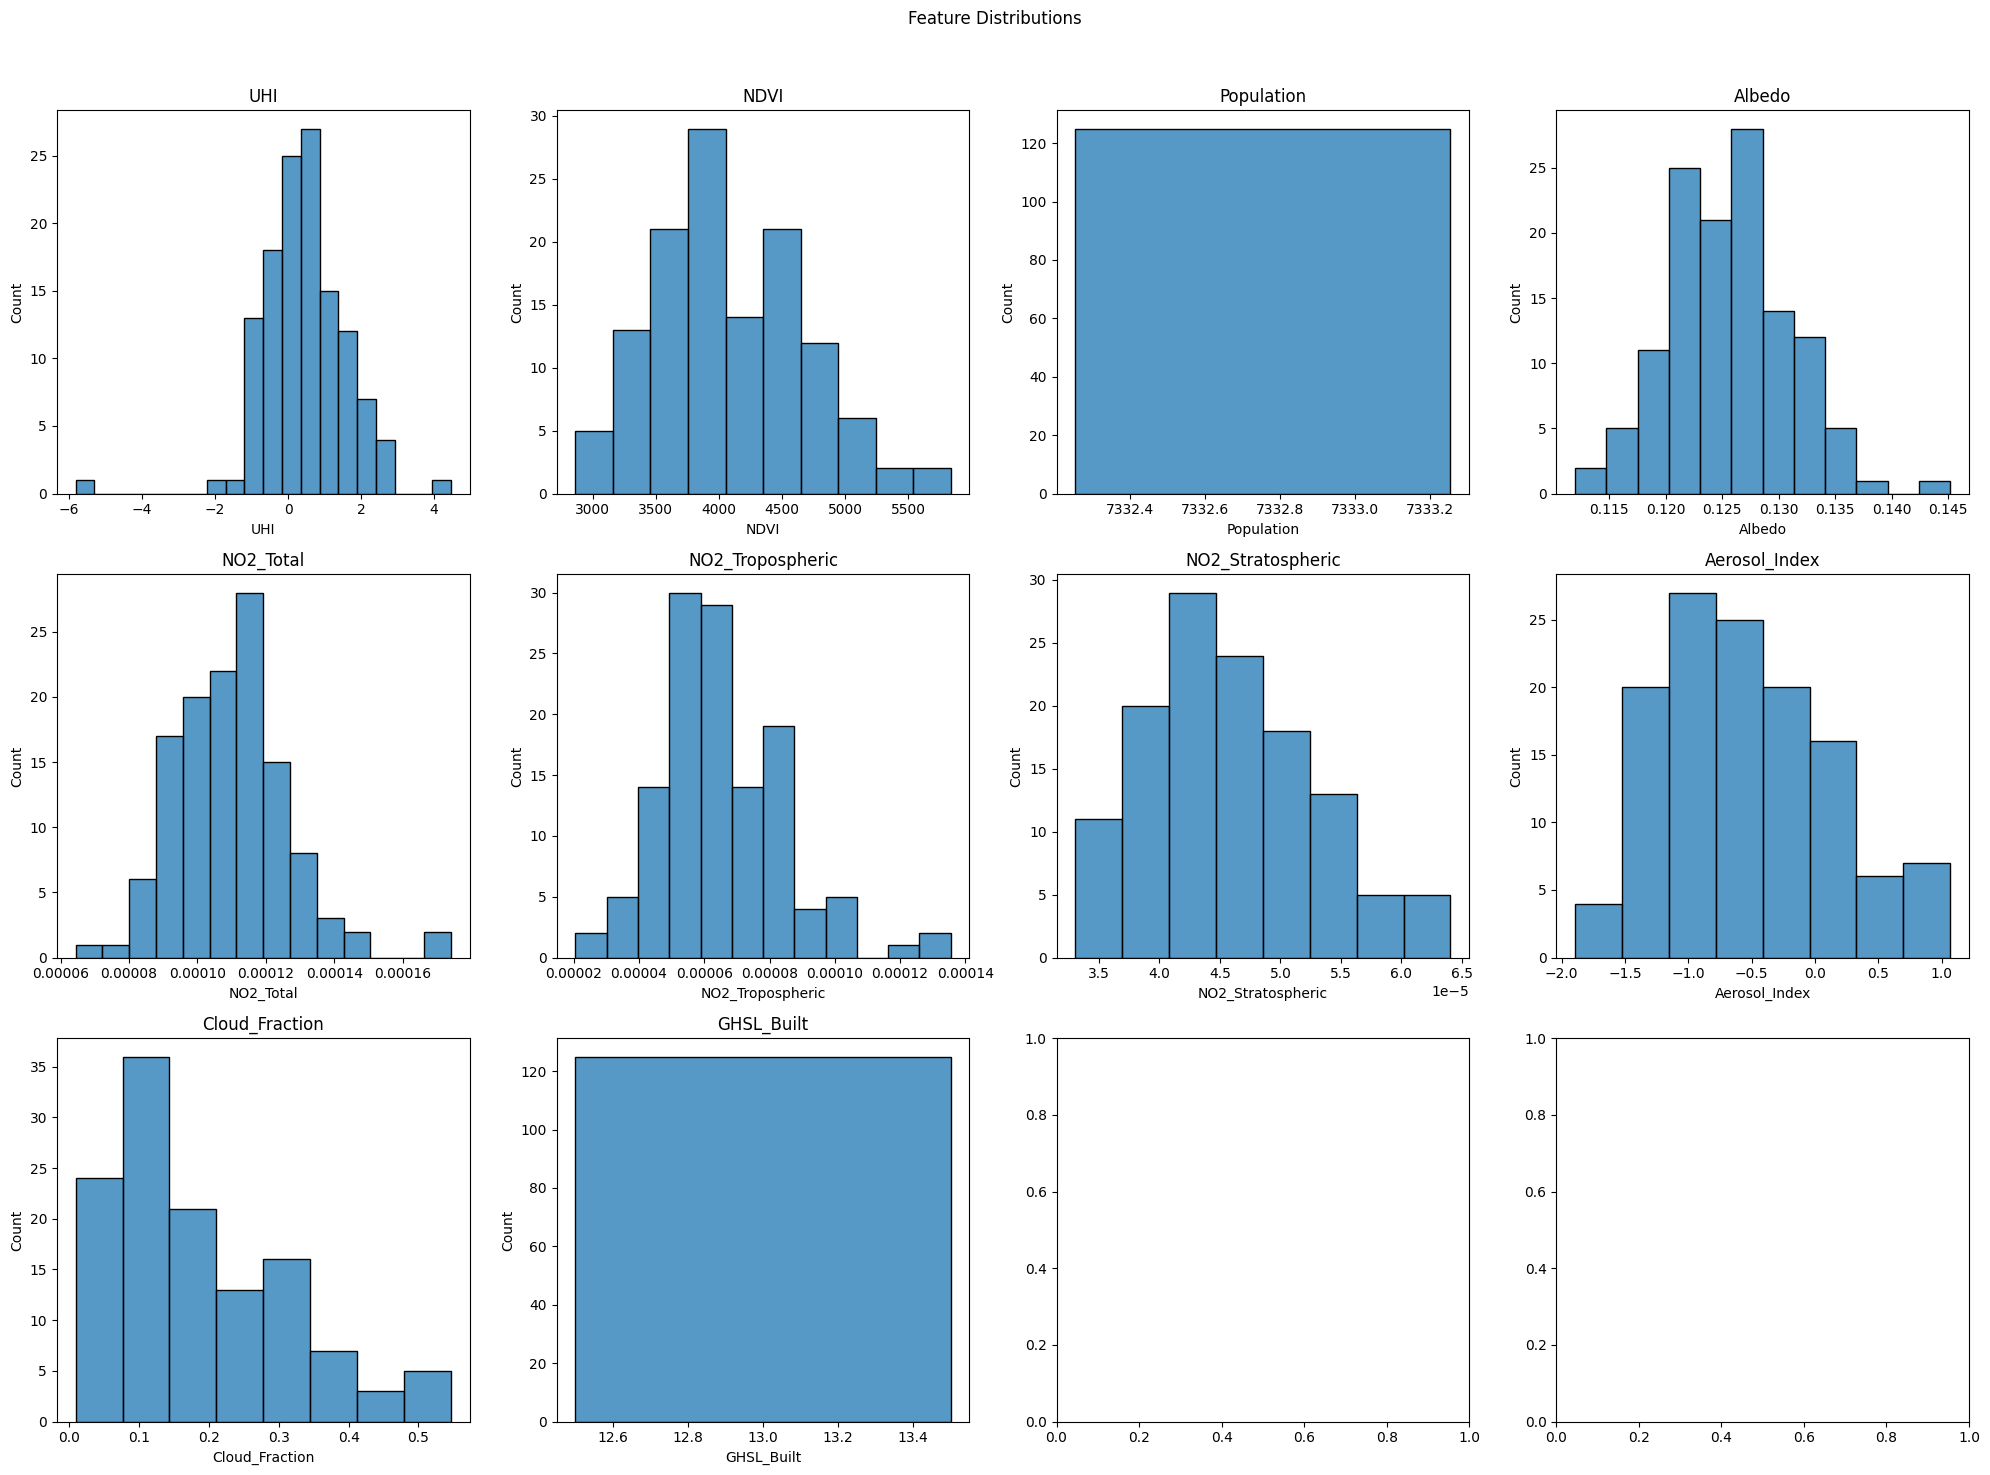

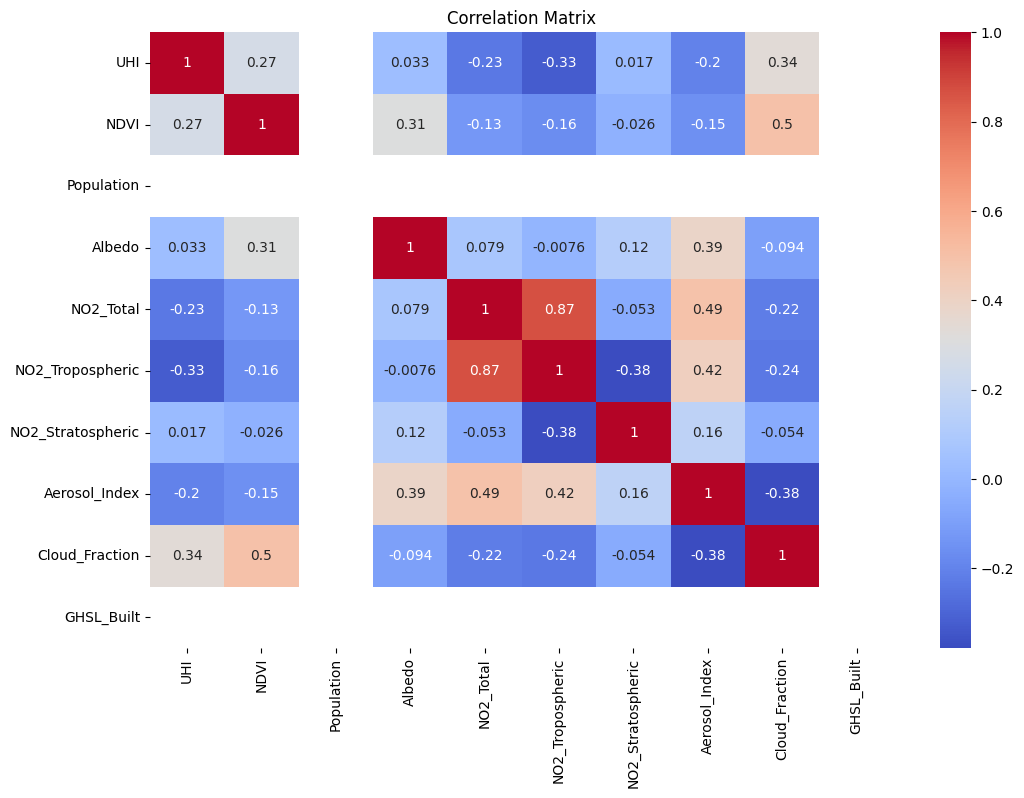

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
fig.suptitle('Feature Distributions')

data = df.copy()
features = data.columns[1:]
for i, feature in enumerate(features):
    sns.histplot(data[feature], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(feature)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/UHI-Mitigation/feature_distributions.png')
plt.show()

corr_matrix = data.drop(columns=['Date']).corr() # Drop the 'Date' column before calculating correlation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('/content/drive/MyDrive/UHI-Mitigation/correlation_matrix.png')
plt.show()


## Hot Spot Identification


In [28]:
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

# K-Means Clustering
X = data[['UHI']]
kmeans = KMeans(n_clusters=5)
data['Hot_Spot'] = kmeans.fit_predict(X)

# Assign Latitude and Longitude for Chandigarh
data['Latitude'] = np.random.uniform(low=30.68, high=30.75, size=len(data))
data['Longitude'] = np.random.uniform(low=76.70, high=76.82, size=len(data))

# Create Folium Map for Chandigarh
m = folium.Map(location=[30.7333, 76.7794], zoom_start=13)  # Chandigarh's central coordinates
heat_data = [[row['Latitude'], row['Longitude'], row['UHI']] for index, row in data.iterrows()]
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file
m.save('/content/drive/MyDrive/UHI-Mitigation/chandigarh_hot_spots_map.html')
m

## Predictive Modeling


Random Forest RMSE: 1.8702485400178106
Random Forest R2 Score: -0.45113083329503056
XGBoost RMSE: 2.085196934789024
XGBoost R2 Score: -0.8038568789394187


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbifk7hln/uy9bmqkf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbifk7hln/a5bb4iwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57650', 'data', 'file=/tmp/tmpbifk7hln/uy9bmqkf.json', 'init=/tmp/tmpbifk7hln/a5bb4iwu.json', 'output', 'file=/tmp/tmpbifk7hln/prophet_model2yudgmc7/prophet_model-20250114093528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-29-c552c5303dc7>:34: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behav

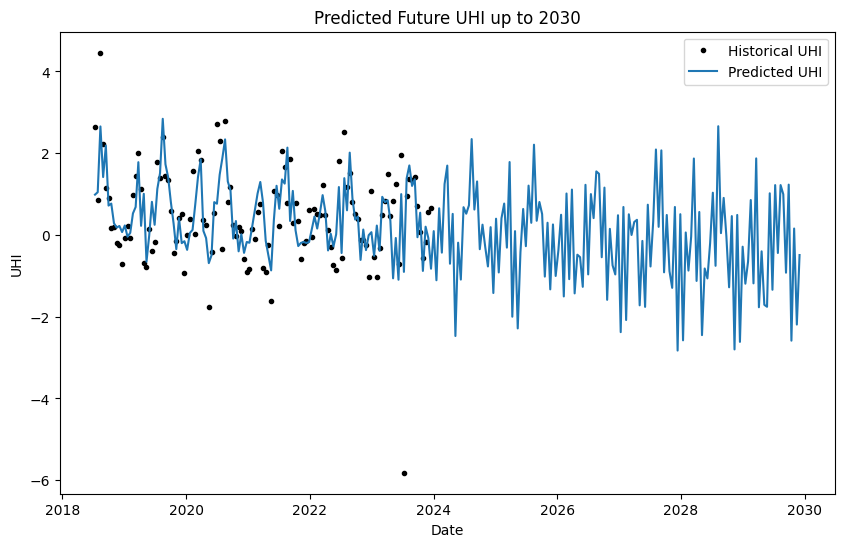

In [29]:
data = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv') # Load the data into a DataFrame

X = data.drop(columns=['Date', 'UHI'])
y = data['UHI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))

from prophet import Prophet

prophet_data = data[['Date', 'UHI']].rename(columns={'Date': 'ds', 'UHI': 'y'})

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.fit(prophet_data)

future_dates = prophet_model.make_future_dataframe(periods=(2030-2024)*365//16, freq='16D')

forecast = prophet_model.predict(future_dates)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.array(prophet_model.history['ds'].dt.to_pydatetime()), np.array(prophet_model.history['y']), 'k.')
ax.plot(np.array(forecast['ds'].dt.to_pydatetime()), np.array(forecast['yhat']), label='Predicted UHI')
ax.set_title('Predicted Future UHI up to 2030')
ax.set_xlabel('Date')
ax.set_ylabel('UHI')
plt.legend(['Historical UHI', 'Predicted UHI'])
plt.show()


## Feature Importance Analysis (Region Wise)



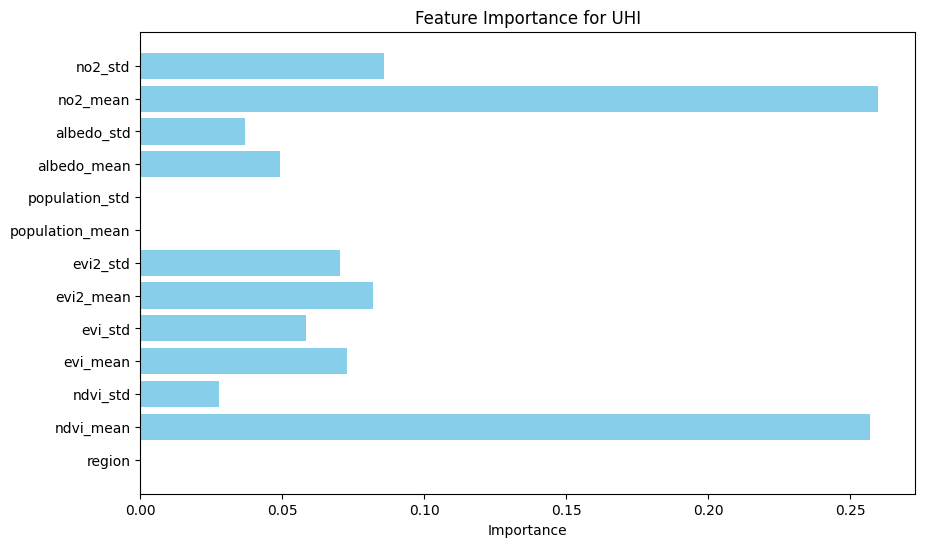

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Ensure categorical data is encoded
rf = rf.copy()
categorical_cols = rf.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    rf[col] = le.fit_transform(rf[col])
    label_encoders[col] = le

# Define features and target
X = rf.drop(columns=['uhi', 'start_date', 'end_date'])
y = rf['uhi']

# Train RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Plot feature importances
importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for UHI')
plt.show()


## Clustering Analysis

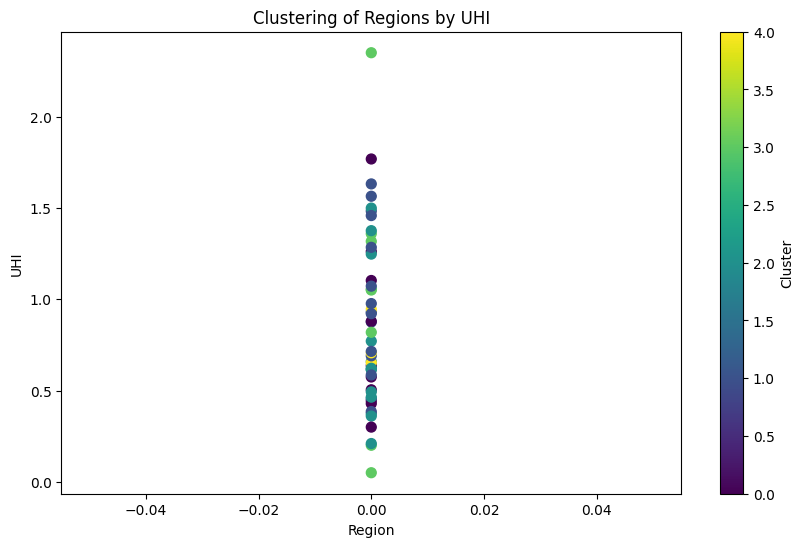

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Impute missing values with the mean
X = X.fillna(X.mean())

# Fit KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Assign clusters to the DataFrame
rf['cluster'] = clusters

# Visualize clustering
plt.figure(figsize=(10, 6))
plt.scatter(rf['region'], rf['uhi'], c=rf['cluster'], cmap='viridis', s=50)
plt.xlabel('Region')
plt.ylabel('UHI')
plt.title('Clustering of Regions by UHI')
plt.colorbar(label='Cluster')
plt.show()


## Gradient Boosting Machines (GBM)
1. Fine-tunes a Gradient Boosting model to improve prediction accuracy for UHI values.
2. Performs hyperparameter tuning using GridSearchCV to optimize parameters like learning rate, max depth, and subsample size.
3. Evaluates the model's performance (RMSE, R²) to assess improvements over previous models.


In [35]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd

# Add calculated columns
rf['ndvi_evi_ratio'] = rf['ndvi_mean'] / (rf['evi_mean'] + 1e-6)
rf['population_density'] = rf['population_mean'] / (rf['region'] + 1e-6)

# Separate features and target
X = rf.drop(columns=['uhi', 'start_date', 'end_date'])
y = rf['uhi']

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_gbm = grid_search.best_estimator_
y_pred_best_gbm = best_gbm.predict(X_test)

# Model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_gbm))
r2 = r2_score(y_test, y_pred_best_gbm)

print("Best GBM RMSE:", rmse)
print("Best GBM R2 Score:", r2)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best GBM RMSE: 0.40796447473186515
Best GBM R2 Score: 0.5113022749274223


## Ensemble Methods (Stacking)

In [36]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

meta_model = LinearRegression()

stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

stacking_regressor.fit(X_train, y_train)

y_pred_stacking = stacking_regressor.predict(X_test)
print("Stacking RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_stacking)))
print("Stacking R2 Score:", r2_score(y_test, y_pred_stacking))


Stacking RMSE: 0.46227592076641516
Stacking R2 Score: 0.37252248401545307


## Cooling Actions Suggestions

Analyzes UHI data for each region and suggests specific mitigation actions:
1. Increase vegetation if NDVI is low.
2. Use reflective materials if albedo is high.
3. Introduce water bodies for regions with high population density.
4. Reduce pollution in areas with high NO2 levels.
5. Saves these suggestions as actionable insights in a CSV file (chandigarh_regions_cooling_actions.csv).

In [39]:
file_path = '/content/drive/MyDrive/UHI-Mitigation/chandigarh_regions_data.csv'
chd_data = pd.read_csv(file_path)

chd_data['albedo_mean'].fillna(chd_data['albedo_mean'].mean(), inplace=True)
chd_data['albedo_std'].fillna(chd_data['albedo_std'].mean(), inplace=True)

chd_data['start_date'] = pd.to_datetime(chd_data['start_date'])
chd_data['end_date'] = pd.to_datetime(chd_data['end_date'])

label_encoder = LabelEncoder()
chd_data['region_encoded'] = label_encoder.fit_transform(chd_data['region'])

region_mapping = dict(zip(chd_data['region_encoded'], chd_data['region']))

numerical_cols = chd_data.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
chd_data[numerical_cols] = scaler.fit_transform(chd_data[numerical_cols])

chd_data['ndvi_evi_ratio'] = chd_data['ndvi_mean'] / (chd_data['evi_mean'] + 1e-6)
chd_data['population_density'] = chd_data['population_mean'] / (chd_data['region_encoded'] + 1e-6)

def suggest_cooling_actions(data, region_mapping):
    actions = {}
    for index, row in data.iterrows():
        region_name = region_mapping[int(row['region_encoded'])]
        if region_name not in actions:
            actions[region_name] = set()
        if row['ndvi_mean'] < 0.2:
            actions[region_name].add('Increase green spaces with trees, green roofs, and green walls.')
        if row['albedo_mean'] > 0.5:
            actions[region_name].add('Use reflective materials for pavements and buildings.')
        if row['population_density'] > 1:
            actions[region_name].add('Introduce or expand water bodies to cool down the area.')
        if row['no2_mean'] > 0.0001:
            actions[region_name].add('Implement pollution control measures to reduce NO2 levels.')
    return actions

cooling_actions = suggest_cooling_actions(chd_data, region_mapping)

action_list = [{'Region': region, 'Actions': ', '.join(actions)} for region, actions in cooling_actions.items()]

actions_df = pd.DataFrame(action_list)

print(actions_df.head(10))

actions_df.to_csv('/content/drive/MyDrive/UHI-Mitigation/chandigarh_regions_cooling_actions.csv', index=False)


     Region                                            Actions
0  Region_1  Implement pollution control measures to reduce...


<ipython-input-39-c6c51bf60320>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chd_data['albedo_mean'].fillna(chd_data['albedo_mean'].mean(), inplace=True)
<ipython-input-39-c6c51bf60320>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

## Conclusion

In this notebook, we have undertaken a comprehensive analysis to understand and mitigate the Urban Heat Island (UHI) effect in Chandigarh city. Here is a summary of the steps and findings:

1. **Data Cleaning and Preprocessing**:
    - We loaded and preprocessed the data, ensuring it was ready for analysis.

2. **Exploratory Data Analysis (EDA)**:
    - Visualized the distribution of various features.
    - Analyzed the correlation between UHI and other features to identify key factors contributing to the UHI effect.

3. **Hot Spot Identification**:
    - Used clustering algorithms to identify hot spots within Chandigarh city where the UHI effect is most pronounced.

4. **Predictive Modeling**:
    - Built and evaluated different machine learning models (Random Forest, XGBoost, LSTM) to predict future UHI values.
    - Finally, we used Facebook Prophet to model and predict UHI values up to 2030.

5. **Cooling Action Suggestions**:
    - Provided actionable suggestions to mitigate the UHI effect, including green roofs, cool pavements, urban forests, water bodies, green walls, and light-colored buildings.

### Key Findings:
- The Random Forest and XGBoost models were able to predict UHI with moderate accuracy. However, their R² scores indicated that there is room for improvement.
- The LSTM model showed limitations in capturing the complex patterns in the data.
- Facebook Prophet provided a robust framework for time series prediction, capturing trends and seasonality.

### Cooling Action Suggestions:
- **Green Roofs**: Planting vegetation on rooftops to absorb less heat.
- **Cool Pavements**: Using reflective materials in pavements to reduce heat absorption.
- **Urban Forests**: Increasing tree cover in urban areas to provide shade and cool the air.
- **Water Bodies**: Creating or restoring water bodies to cool the surrounding area.
- **Green Walls**: Installing vertical gardens on building facades to reduce heat.
- **Light-Colored Buildings**: Using light-colored materials for buildings to reflect more sunlight and absorb less heat.
